In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from scipy import stats


%matplotlib inline
# unicode minus를 사용하지 않기 위한 설정 (minus 깨짐현상 방지)
plt.rcParams['axes.unicode_minus'] = False
# plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['font.family'] = 'Malgun Gothic'


## 데이터셋

In [2]:
reviews_3527 = pd.read_csv("data/reviews_3527.csv")
reviews_3527_4176 = pd.read_csv("data/reviews_3527_4176.csv")
reviews_4176_8352 = pd.read_csv("data/reviews_4176_8352.csv")
reviews_8352 = pd.read_csv("data/reviews_8352.csv")

In [3]:
# 모범식당인 것은 1, 모범식당이 아닌 것은 0으로 mapping
reviews_3527['is_model_b'] = reviews_3527['is_model'].map({np.nan: 0, '모범식당지정': 1})
reviews_3527_4176['is_model_b'] = reviews_3527_4176['is_model'].map({np.nan: 0, '모범식당지정': 1})

## 전처리

In [4]:
reviews = pd.concat((reviews_3527, reviews_3527_4176, reviews_4176_8352, reviews_8352), sort = False)

In [5]:
def data_preprocessing(data):

    # 리뷰 내용 유무 담은 binary 컬럼 생성
    data['is_review'] = (data['review'].notnull()).astype("int")

    # 평점 편향 제거
    data['adjusted_rate'] = data['rate'] / data['avg_rate']

    # 평점 편향 제거한 컬럼 로그변환
    data['log_rate'] = data['adjusted_rate'].apply(np.log1p)
    
    return data

In [6]:
reviews = data_preprocessing(reviews)

In [7]:
reviews.head(3)

,name,user,review,date,rate,avg_rate,review_cnt,is_model,is_model_b,Unnamed: 0,new_name,is_review,adjusted_rate,log_rate
0,브래서리,Navio,강남에 있는 비싸고 좋다는 호텔 뷔페들 가봤는데 여기가 제일 괜찮네요. 종류도 많고...,2024.04.15.,4,2.5,2,모범식당지정,1,NaN,NaN,1,1.600000,0.955511
1,브래서리,Chris,"맛있는 저녁 먹었어요. 가을부터 1년간 리모델링 들어가니, 그 전에 한 번 더 가야...",2024.03.01.,4,2.3,22,모범식당지정,1,NaN,NaN,1,1.739130,1.007641
2,브래서리,구리리리리,삼성역 호텔 뷔페중 여기가 제일 만족! 점심 저녁 둘다 먹어봤는데 메뉴가 아쉽지도 ...,2023.12.20.,5,4.1,35,모범식당지정,1,NaN,NaN,1,1.219512,0.797287


In [8]:
def grouping(data, n_review_cnt_under=0):
    # 1 rate adjusting 
    # data['adjusted_rate'] = data['rate'] / data['avg_rate']
    
    # delete restaurants with reviews less than n
    temp = data.groupby(["name", "is_model_b"]).agg({"adjusted_rate":["count", stats.gmean]})

    dataset = temp[temp["adjusted_rate"]["count"] > n_review_cnt_under]
    dataset = dataset.droplevel(level=0, axis=1)

    
    dataset.columns = ['review_cnt', 'rate_gmean']
    dataset["log_rate_gmean"] = dataset["rate_gmean"].apply(np.log1p)
    
    return dataset

In [9]:
reviews_model = reviews[reviews['is_model'] == "모범식당지정"]
reviews_no_model = reviews[reviews['is_model'] != "모범식당지정"]

In [10]:
# 리뷰 개수 제한 (ex. 10개 이상)
review_cnt = 10

reviews_group = grouping(reviews, review_cnt).reset_index()
reviews_group_model = grouping(reviews_model, review_cnt).reset_index()
reviews_group_no_model = grouping(reviews_no_model, review_cnt).reset_index()

In [11]:
reviews_group

,name,is_model_b,review_cnt,rate_gmean,log_rate_gmean
0,보코서울강남,0,18,0.999651,0.692973
1,타워그안,0,20,0.770020,0.570991
2,(주)감성타코 강남역점,0,142,0.800114,0.587850
3,(주)낙타브루잉,0,22,0.841082,0.610354
4,(주)더휴컨벤션,0,12,0.732029,0.549294
...,...,...,...,...,...
2230,히노카츠,0,50,1.112072,0.747670
2231,히라이,0,12,0.739857,0.553803
2232,히로아키,0,20,1.222931,0.798827
2233,히로야,0,23,0.974868,0.680502


In [12]:
reviews.shape, reviews_group.shape, reviews_group_model.shape, reviews_group_no_model.shape

((97992, 14), (2235, 5), (164, 5), (2071, 5))

In [13]:
# 리뷰 개수 제한한 음식점 목록을 바탕으로, reviews 데이터프레임 필터링
reviews = reviews[reviews.name.isin(reviews_group["name"])]
reviews.shape

(82583, 14)

In [14]:
reviews.head(3)

,name,user,review,date,rate,avg_rate,review_cnt,is_model,is_model_b,Unnamed: 0,new_name,is_review,adjusted_rate,log_rate
0,브래서리,Navio,강남에 있는 비싸고 좋다는 호텔 뷔페들 가봤는데 여기가 제일 괜찮네요. 종류도 많고...,2024.04.15.,4,2.5,2,모범식당지정,1,NaN,NaN,1,1.600000,0.955511
1,브래서리,Chris,"맛있는 저녁 먹었어요. 가을부터 1년간 리모델링 들어가니, 그 전에 한 번 더 가야...",2024.03.01.,4,2.3,22,모범식당지정,1,NaN,NaN,1,1.739130,1.007641
2,브래서리,구리리리리,삼성역 호텔 뷔페중 여기가 제일 만족! 점심 저녁 둘다 먹어봤는데 메뉴가 아쉽지도 ...,2023.12.20.,5,4.1,35,모범식당지정,1,NaN,NaN,1,1.219512,0.797287


In [15]:
reviews.isnull().sum()

name                 0
user                64
review           14902
date                 0
rate                 0
avg_rate             0
review_cnt           0
is_model         75135
is_model_b           0
Unnamed: 0       39535
new_name         39535
is_review            0
adjusted_rate        0
log_rate             0
dtype: int64

## 가설 검정

### 1. 리뷰 없이 별점만 매긴 사람과 리뷰를 적은 사람의 평균 평점이 차이가 있을까?
- 귀무가설 : 리뷰 없이 별점만 매긴 사람과 리뷰를 적은 사람의 평균 평점이 차이가 없다

- 대립가설 : 리뷰 없이 별점만 매긴 사람과 리뷰를 적은 사람의 평균 평점이 차이가 있다

#### 정규성 검정

In [16]:
def normal_check(data, column='rate_gmean'):

    # 표본이 크기 때문에 Kolmogorov-Smirnov 검정 사용
    # https://datadoctorblog.com/2023/10/12/Py-Stat-Test-Normality/

    # kolmogorov-Smirnov 검정 (kstest)에서 p-value=0 일때 해결책
    # https://stackoverflow.com/questions/46678239/p-value-is-0-when-i-use-scipy-stats-kstest-for-large-dataset
    # -> stats.kstest(data[column], "norm", arges(data[column].mean(), data[column].var()**0.5)) 와 동일

    # loc, scale = stats.norm.fit(data[column])
    # n = stats.norm(loc=loc, scale=scale)

    # kolmogorov-Smirnov 검정 사용
    # statistic, p_value = stats.kstest(data[column], n.cdf)
    # print("kolmogorov-Smirnov 통계량:", statistic)
    
    
    # Anderson-Darling 검정 사용

    # 참고 링크
    # - https://stackoverflow.com/questions/7903977/implementing-a-kolmogorov-smirnov-test-in-python-scipy
    # - https://datadoctorblog.com/2023/10/12/Py-Stat-Test-Normality/
    # - https://dibrary.tistory.com/61

    statistics, critical_values, significance_level = stats.anderson(data[column], dist="norm")
    anderson_result = pd.DataFrame([critical_values, significance_level]).transpose()
    anderson_result.columns = ["critical_values", "significance_level"]
    anderson_result["reject"] = anderson_result["critical_values"] < statistics

    print("Anderson-Darling 검정통계량:", statistics)
    if anderson_result.loc[2, "reject"]:
        print(f"Anderson-Darling 검정결과 : 유의수준 {anderson_result.loc[2, 'significance_level']}에서 검정통계량 {statistics}이 기각역 {anderson_result.loc[2, 'critical_values']} 보다 크기 때문에 정규성을 만족하지 않는다")
    else:
        print("Anderson-Darling 검정결과 : 5% 유의수준에서 정규성 만족")
    
    # return anderson_result

In [17]:
# 리뷰가 없는 데이터와 리뷰가 있는 데이터로 나눈다
no_review = reviews[reviews.is_review == 0]
yes_review = reviews[reviews.is_review == 1]

In [18]:
# 전체 데이터셋
normal_check(reviews, "adjusted_rate")

Anderson-Darling 검정통계량: 2104.9934582749265
Anderson-Darling 검정결과 : 유의수준 5.0에서 검정통계량 2104.9934582749265이 기각역 0.787 보다 크기 때문에 정규성을 만족하지 않는다


In [19]:
# 리뷰가 있는 데이터
normal_check(yes_review, "adjusted_rate")


Anderson-Darling 검정통계량: 1699.6903348277701
Anderson-Darling 검정결과 : 유의수준 5.0에서 검정통계량 1699.6903348277701이 기각역 0.787 보다 크기 때문에 정규성을 만족하지 않는다


In [20]:
# 리뷰가 없는 데이터
normal_check(no_review, "adjusted_rate")

Anderson-Darling 검정통계량: 392.73614494886715
Anderson-Darling 검정결과 : 유의수준 5.0에서 검정통계량 392.73614494886715이 기각역 0.787 보다 크기 때문에 정규성을 만족하지 않는다


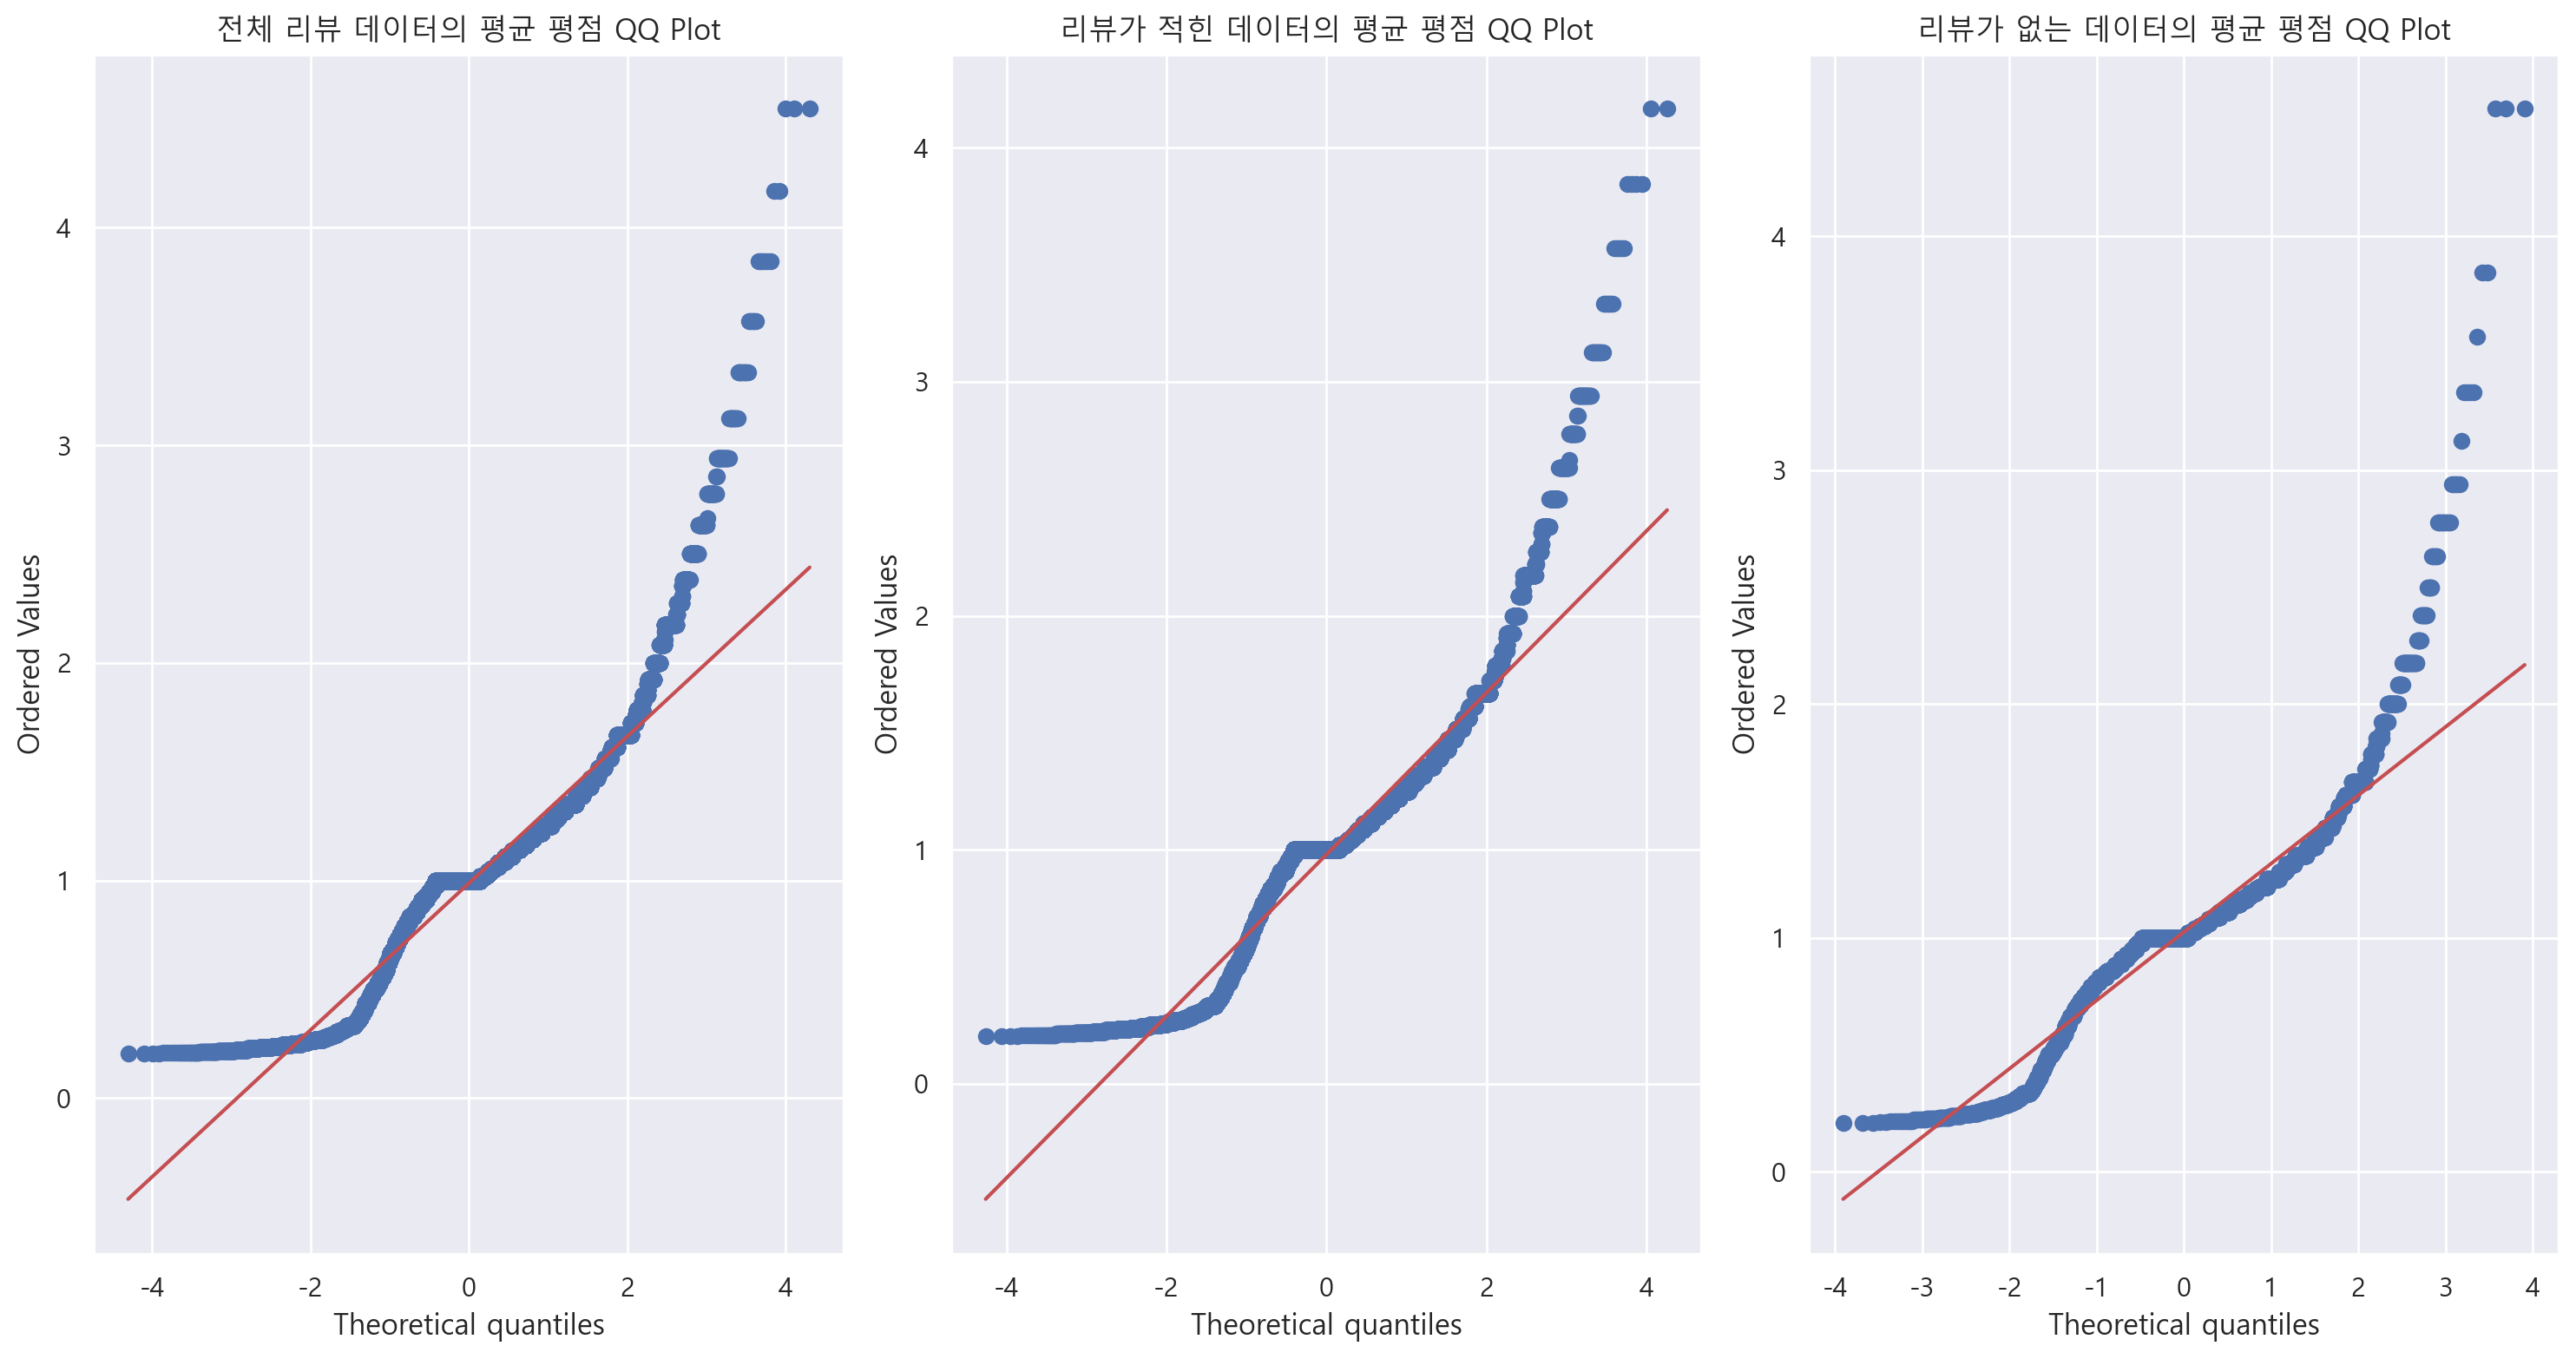

In [21]:
# 전체 데이터 (not grouped) QQ Plot
# 정규성을 띄지 않는다

fig = plt.figure(figsize=(15, 8))
ax1 = fig.add_subplot(1, 3, 1)
ax2 = fig.add_subplot(1, 3, 2)
ax3 = fig.add_subplot(1, 3, 3)

stats.probplot(reviews["adjusted_rate"], dist=stats.norm, plot=ax1)
stats.probplot(yes_review["adjusted_rate"], dist=stats.norm, plot=ax2)
stats.probplot(no_review["adjusted_rate"], dist=stats.norm, plot=ax3)

ax1.set_title("전체 리뷰 데이터의 평균 평점 QQ Plot")
ax2.set_title("리뷰가 적힌 데이터의 평균 평점 QQ Plot")
ax3.set_title("리뷰가 없는 데이터의 평균 평점 QQ Plot")

plt.tight_layout()
plt.show()

#### 비모수적 검정

In [64]:
def non_parametic_check(df1, df2, column, alternative='two-sided'):
    
    # Mann-Whitney U test
    statistic, p_value = stats.mannwhitneyu(df1[column], df2[column], alternative=alternative)

    print("Mann-Whitney U test 통계량:", statistic)
    print("p-value:", p_value)
    if p_value < 0.05:
        print("검정결과 : 귀무가설을 기각한다")
    else:
        print("검정결과 : 5% 유의수준에서 귀무가설을 채택한다")

In [65]:
# Mann-Whitney 테스트 적용
non_parametic_check(no_review, yes_review, "log_rate")

Mann-Whitney U test 통계량: 535086321.0
p-value: 6.986017493536782e-32
검정결과 : 귀무가설을 기각한다


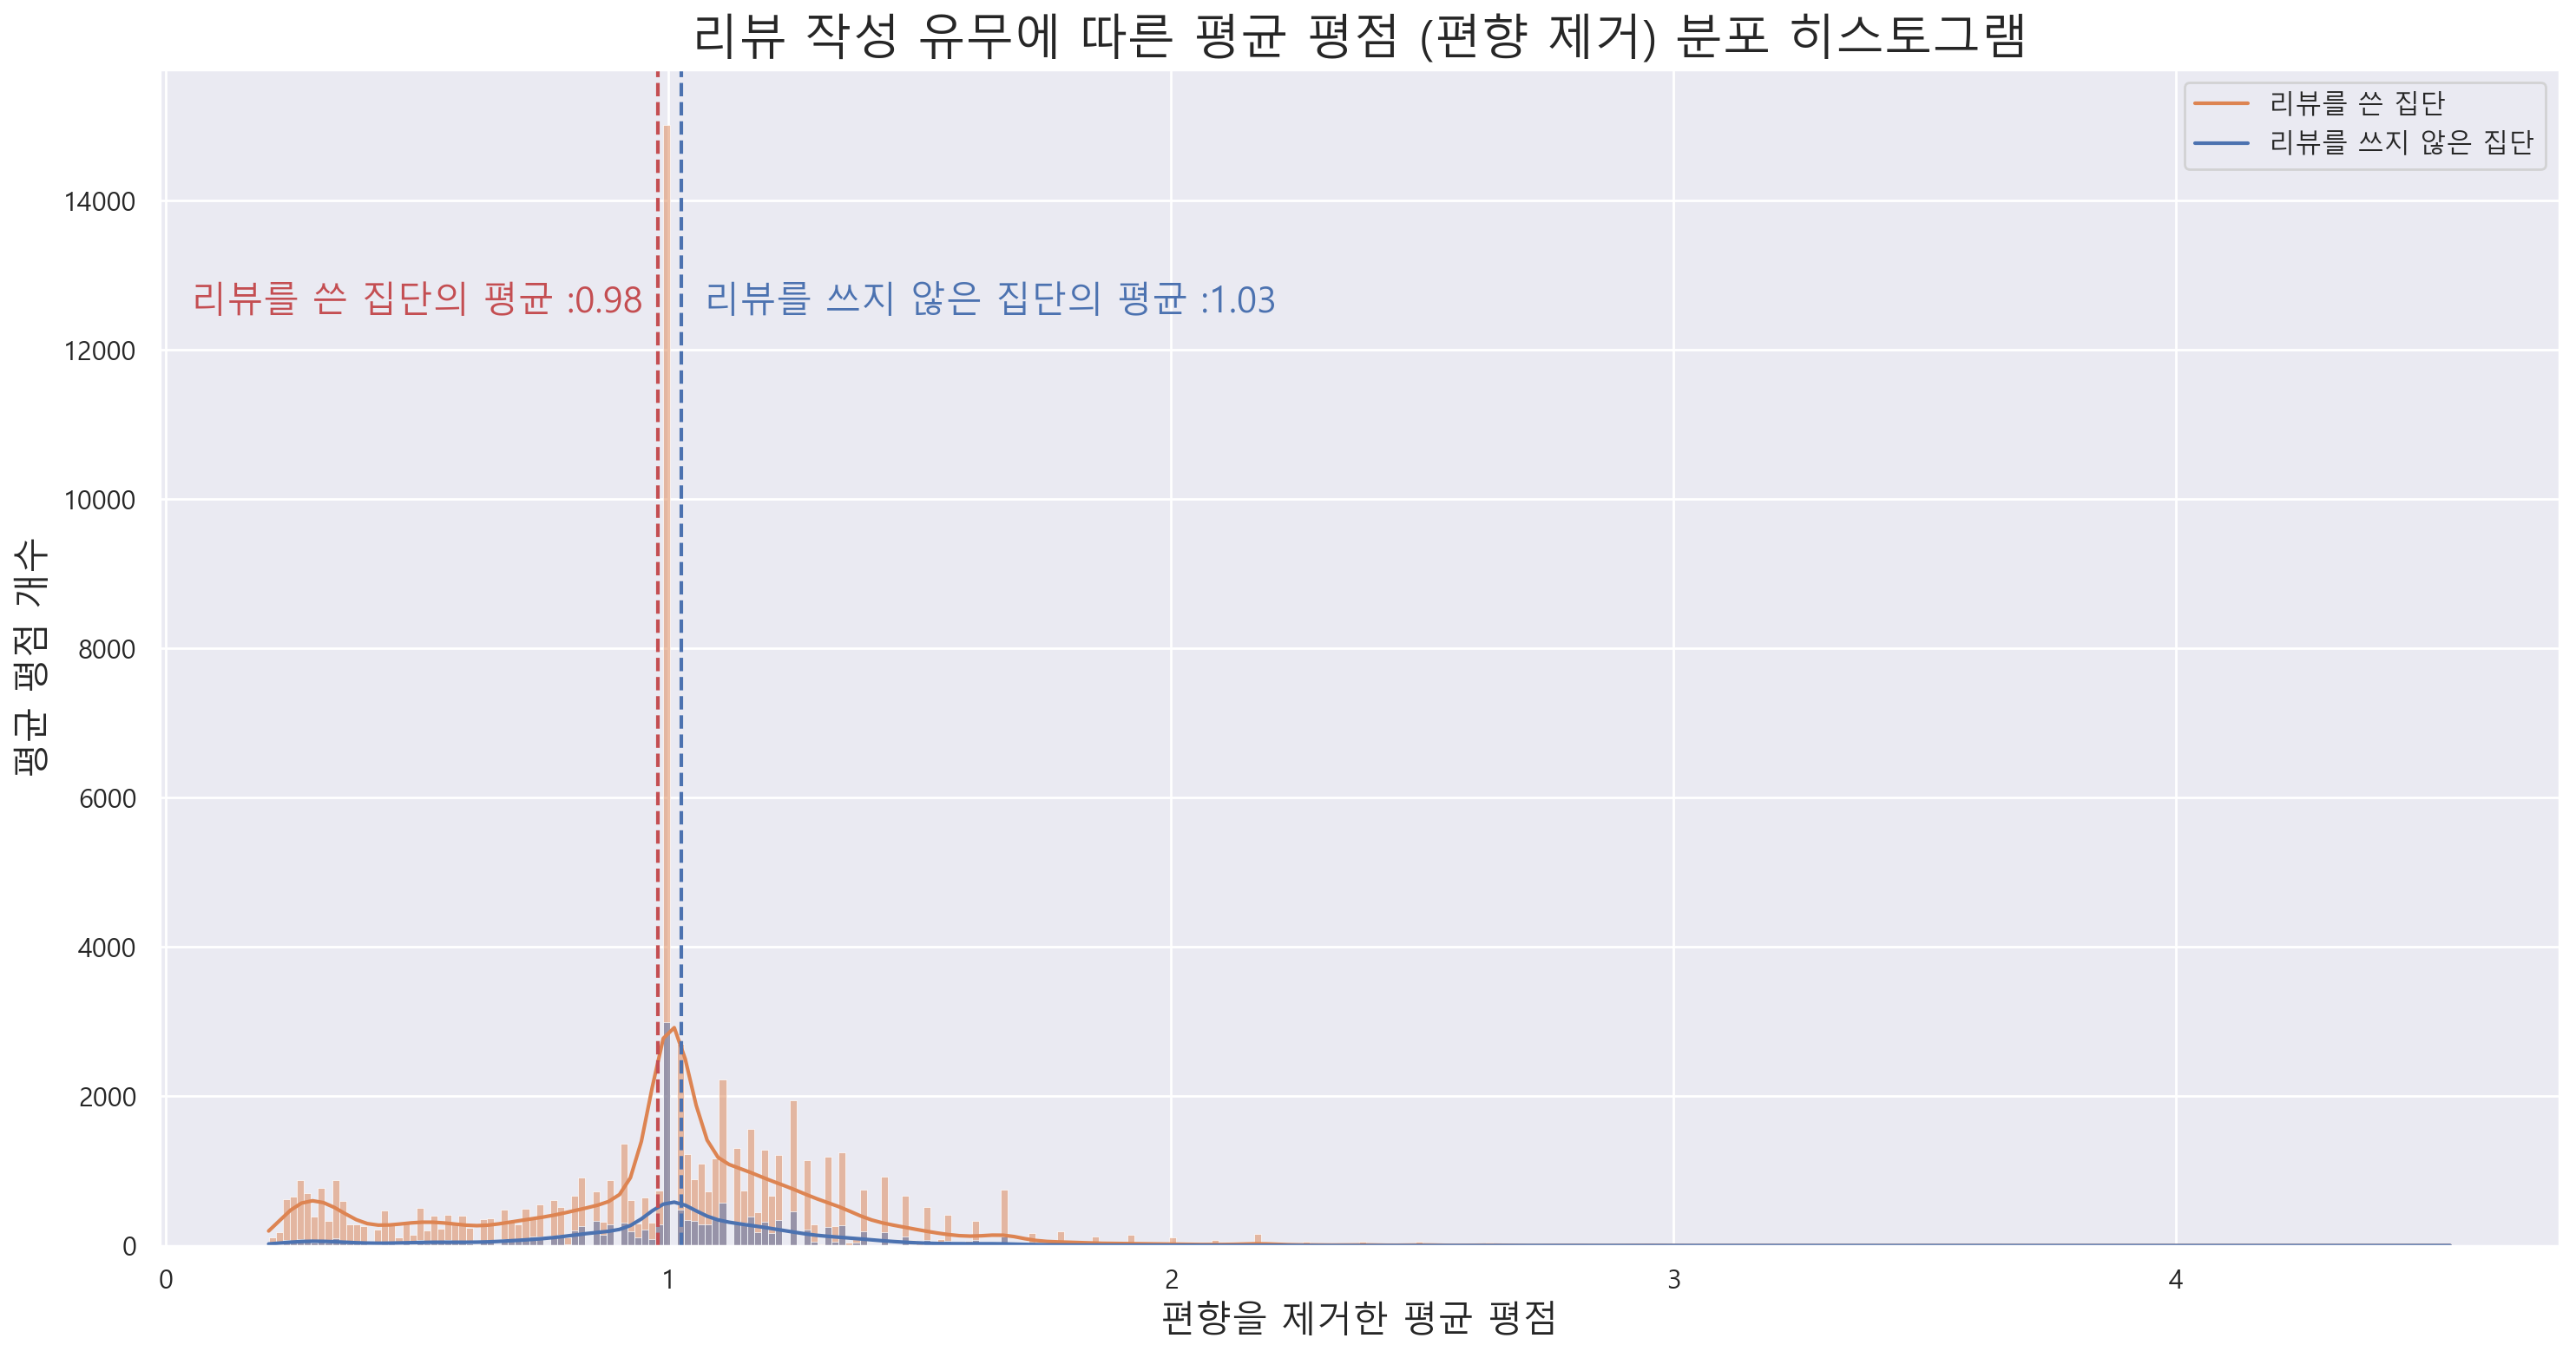

In [24]:
# 리뷰를 쓴 집단과 쓰지 않은 집단의 평균 평점 분포 비교
# 그냥 평점 사용할까? (정규님 의견)

plt.figure(figsize=(15, 8))
sns.histplot(data=reviews, x="adjusted_rate", hue="is_review", kde=True)

plt.axvline(np.mean(no_review["adjusted_rate"]), color="b", linestyle="--")
plt.axvline(np.mean(yes_review["adjusted_rate"]), color="r", linestyle="--")

plt.text(0.05, 12500, "리뷰를 쓴 집단의 평균 :"+str(round(np.mean(yes_review["adjusted_rate"]),2)), 
         color="r", size=15, 
        #  weight="bold"
         )
plt.text(1.07, 12500, "리뷰를 쓰지 않은 집단의 평균 :"+str(round(np.mean(no_review["adjusted_rate"]),2)), 
         color="b", size=15, 
        #  weight="bold"
         )

plt.legend(("리뷰를 쓴 집단", "리뷰를 쓰지 않은 집단"), 
        #    prop={'weight':'bold'}
           )
plt.rc("legend", fontsize=15)


plt.xlabel("편향을 제거한 평균 평점", size=15)
plt.ylabel("평균 평점 개수", size=15)

plt.title("리뷰 작성 유무에 따른 평균 평점 (편향 제거) 분포 히스토그램", size=20)

plt.tight_layout()
plt.show()

##### 가설 검정 결론
- p-value < 0.05 : 귀무가설 기각

    - 리뷰를 쓴 집단과 쓰지 않은 집단의 평균 평점에는 차이가 존재할 수 있다
    
    - 귀무가설이 통계적으로 유의하지 않다

### 2. 리뷰 개수는 평균 평점과 연관이 있을까?
- 귀무가설 : 리뷰 개수의 중위값보다 리뷰를 적게 쓰는 집단과 많이 쓰는 집단의 평균 평점 차이가 없다

- 대립가설 : 리뷰 개수의 중위값보다 리뷰를 적게 쓰는 집단과 많이 쓰는 집단의 평균 평점 차이가 있다

In [25]:
# 중위값 확인
reviews.describe()

,rate,avg_rate,review_cnt,is_model_b,Unnamed: 0,is_review,adjusted_rate,log_rate
count,82583.000000,82583.000000,82583.000000,82583.000000,43048.000000,82583.000000,82583.000000,82583.000000
mean,3.809803,3.855115,164.172239,0.090188,24792.072710,0.819551,0.987788,0.670817
std,1.476035,0.943638,650.634927,0.286453,14306.427146,0.384563,0.350135,0.183332
min,1.000000,1.000000,1.000000,0.000000,3.000000,0.000000,0.204082,0.185717
25%,3.000000,3.400000,7.000000,0.000000,12429.750000,1.000000,0.857143,0.619039
50%,4.000000,4.000000,30.000000,0.000000,24701.500000,1.000000,1.000000,0.693147
75%,5.000000,4.600000,106.000000,0.000000,37081.250000,1.000000,1.162791,0.771399
max,5.000000,5.000000,8538.000000,1.000000,49956.000000,1.000000,4.545455,1.712979


#### 정규성 검정
- `normal_check` 함수 사용

In [26]:
less_median = reviews[reviews["review_cnt"] < np.median(reviews["review_cnt"])]
more_median = reviews[reviews["review_cnt"] >= np.median(reviews["review_cnt"])]

In [27]:
normal_check(less_median, "adjusted_rate")

Anderson-Darling 검정통계량: 1898.3711953345774
Anderson-Darling 검정결과 : 유의수준 5.0에서 검정통계량 1898.3711953345774이 기각역 0.787 보다 크기 때문에 정규성을 만족하지 않는다


In [28]:
normal_check(more_median, "adjusted_rate")

Anderson-Darling 검정통계량: 575.4101656285638
Anderson-Darling 검정결과 : 유의수준 5.0에서 검정통계량 575.4101656285638이 기각역 0.787 보다 크기 때문에 정규성을 만족하지 않는다


#### 비모수적 검정

- 데이터가 정규성을 따르지 않는 것 확인

- 따라서, 비모수적 검정 시행

In [29]:
non_parametic_check(less_median, more_median, "log_rate")

Mann-Whitney U test 통계량: 804202577.0
p-value: 1.6373230850809057e-45
검정결과 : 귀무가설을 기각한다


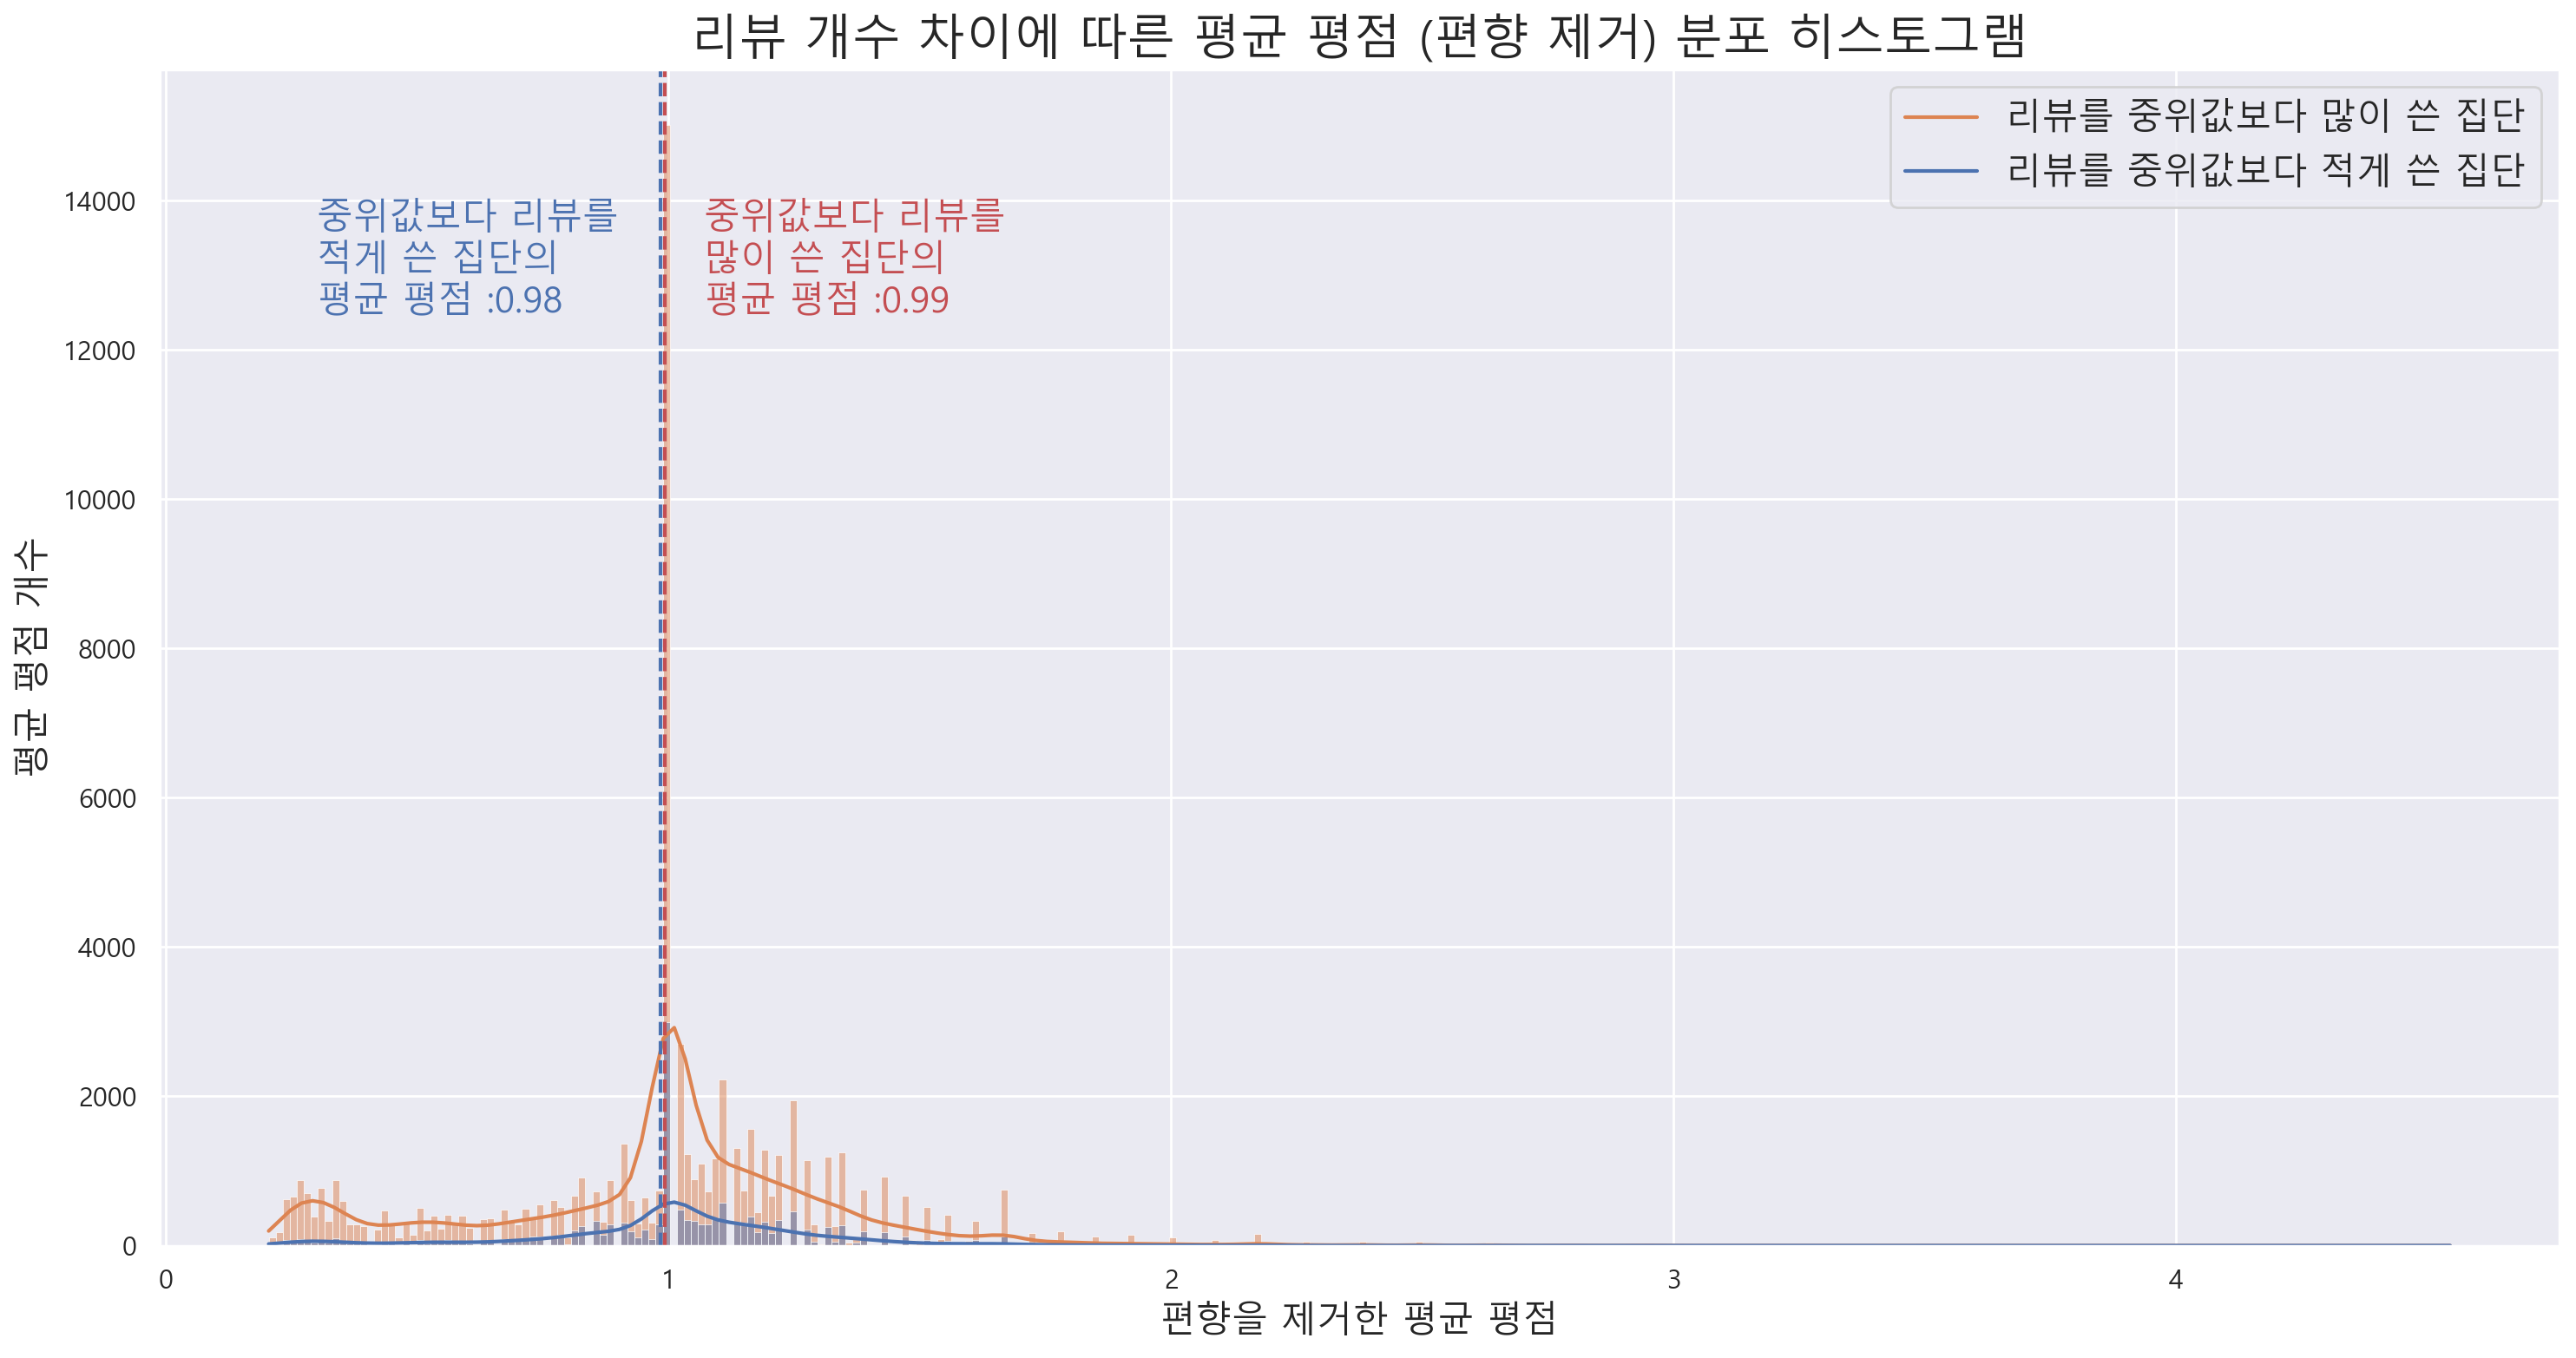

In [30]:
# 리뷰를 쓴 집단과 쓰지 않은 집단의 평균 평점 분포 비교
plt.figure(figsize=(15, 8))
sns.histplot(data=reviews, x="adjusted_rate", hue="is_review", kde=True)

plt.axvline(np.mean(less_median["adjusted_rate"]), color="b", linestyle="--")
plt.axvline(np.mean(more_median["adjusted_rate"]), color="r", linestyle="--")

plt.text(0.3, 12500, "중위값보다 리뷰를 \n적게 쓴 집단의 \n평균 평점 :"+str(round(np.mean(less_median["adjusted_rate"]),2)), 
         color="b", size=15, 
        #  weight="bold"
         )

plt.text(1.07, 12500, "중위값보다 리뷰를\n많이 쓴 집단의 \n평균 평점 :"+str(round(np.mean(more_median["adjusted_rate"]),2)), 
         color="r", size=15, 
        #  weight="bold"
         )


plt.legend(("리뷰를 중위값보다 많이 쓴 집단", "리뷰를 중위값보다 적게 쓴 집단"), 
        #    prop={'weight':'bold'}
           )
plt.rc("legend", fontsize=15)


plt.xlabel("편향을 제거한 평균 평점", size=15)
plt.ylabel("평균 평점 개수", size=15)

plt.title("리뷰 개수 차이에 따른 평균 평점 (편향 제거) 분포 히스토그램", size=20)

plt.tight_layout()
plt.show()

##### 결론
- p-value < 0.05 : 귀무가설 기각

    - 중위값보다 리뷰 개수를 적게 쓰는 집단과 많이 쓰는 집단의 평균 평점 차이가 있다고 볼 수 있다
    
    - 귀무가설이 통계적으로 유의하지 않다

### 3. 강남구 모범음식점과 일반음식점의 평균 평점이 유의미한 차이를 갖고 있을까?

- 귀무가설 : 모범음식점과 일반음식점의 평균 평점은 유의미한 차이가 없다

- 대립가설 : 모범음식점과 일반음식점의 평균 평점은 유의미한 차이가 있다

#### 정규성 검정

- `normal_check` 함수 사용

In [31]:
# 음식점으로 groupby한 데이터
normal_check(reviews_group)

Anderson-Darling 검정통계량: 5.920090016776157
Anderson-Darling 검정결과 : 유의수준 5.0에서 검정통계량 5.920090016776157이 기각역 0.786 보다 크기 때문에 정규성을 만족하지 않는다


In [32]:
# 음식점으로 groupby한 데이터 중 모범 음식점
normal_check(reviews_group_model)

Anderson-Darling 검정통계량: 0.8296607982341584
Anderson-Darling 검정결과 : 유의수준 5.0에서 검정통계량 0.8296607982341584이 기각역 0.769 보다 크기 때문에 정규성을 만족하지 않는다


In [33]:
# 음식점으로 groupby한 데이터 중 일반 음식점
normal_check(reviews_group_no_model)

Anderson-Darling 검정통계량: 5.55052145678701
Anderson-Darling 검정결과 : 유의수준 5.0에서 검정통계량 5.55052145678701이 기각역 0.785 보다 크기 때문에 정규성을 만족하지 않는다


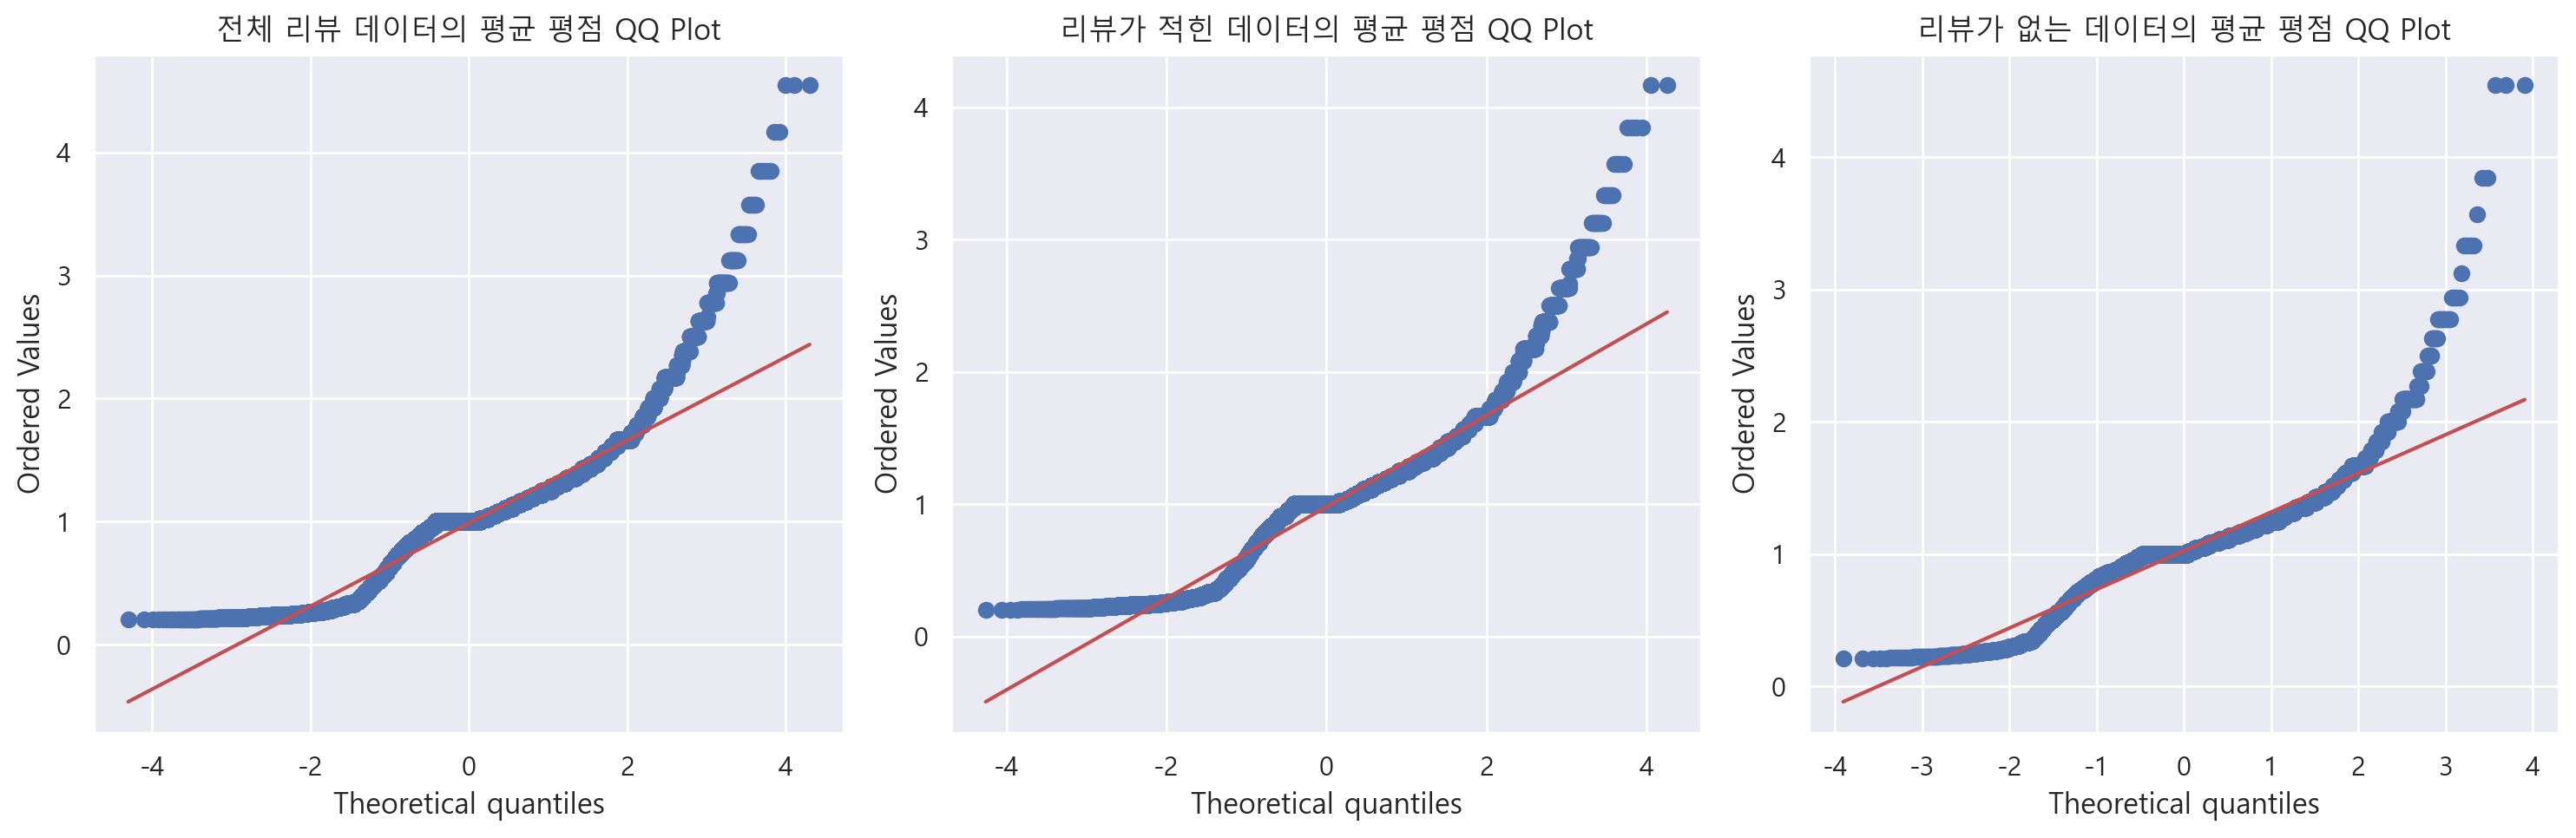

In [34]:
# 전체 데이터 (not grouped) QQ Plot
# 정규성을 띄지 않는다
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(1, 3, 1)
ax2 = fig.add_subplot(1, 3, 2)
ax3 = fig.add_subplot(1, 3, 3)

stats.probplot(reviews["adjusted_rate"], dist=stats.norm, plot=ax1)
stats.probplot(reviews[reviews.is_review==1]["adjusted_rate"], dist=stats.norm, plot=ax2)
stats.probplot(reviews[reviews.is_review==0]["adjusted_rate"], dist=stats.norm, plot=ax3)

# ax1.set_title("QQ Plot for Total Reviews")
# ax2.set_title("QQ Plot for Written Reviews")
# ax3.set_title("QQ Plot for Blank Reviews")

ax1.set_title("전체 리뷰 데이터의 평균 평점 QQ Plot")
ax2.set_title("리뷰가 적힌 데이터의 평균 평점 QQ Plot")
ax3.set_title("리뷰가 없는 데이터의 평균 평점 QQ Plot")

plt.tight_layout()
plt.show()

#### 비모수적 검정

- 데이터가 정규성을 따르지 않는 것 확인

- 따라서, 비모수적 검정 시행

In [35]:
non_parametic_check(reviews_group_model, reviews_group_no_model, "log_rate_gmean")

Mann-Whitney U test 통계량: 156138.0
p-value: 0.08542415983080766
검정결과 : 5% 유의수준에서 귀무가설을 채택한다


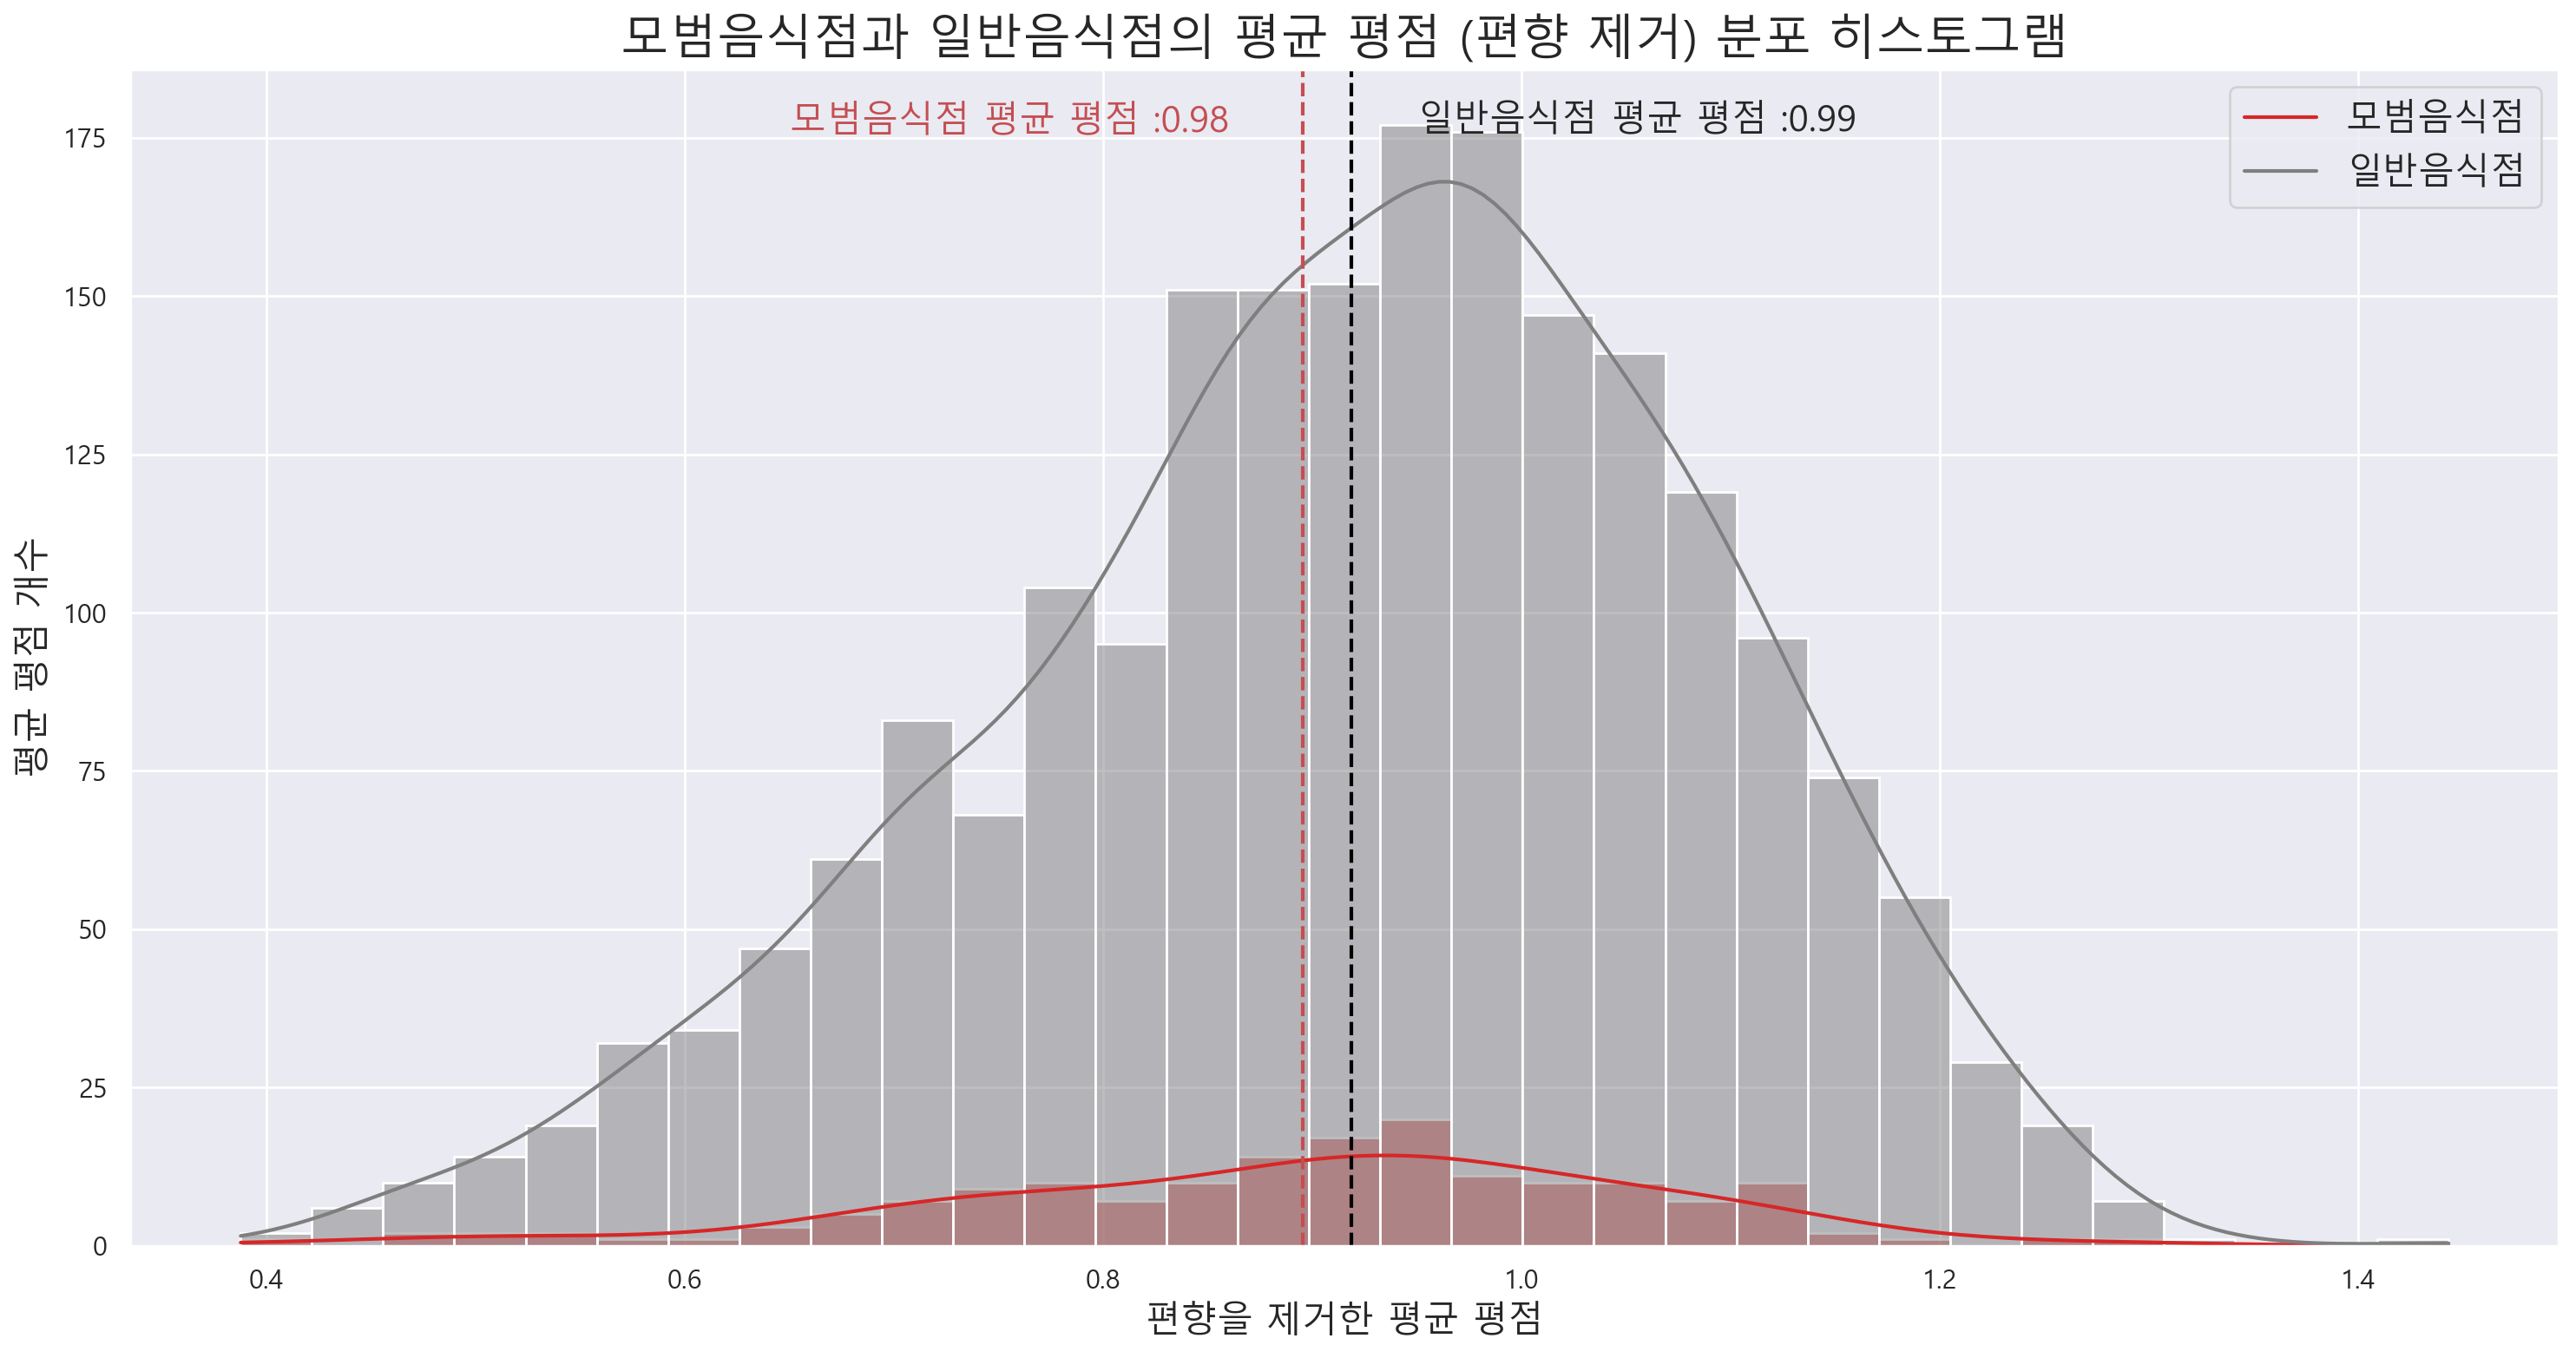

In [36]:
# 리뷰를 쓴 집단과 쓰지 않은 집단의 평균 평점 분포 비교

palette = ['tab:grey', 'tab:red']

plt.figure(figsize=(15, 8))
sns.histplot(data=reviews_group, x="rate_gmean", hue="is_model_b", kde=True, palette=palette)

plt.axvline(np.mean(reviews_group_model["rate_gmean"]), color="r", linestyle="--")
plt.axvline(np.mean(reviews_group_no_model["rate_gmean"]), color="black", linestyle="--")

plt.text(0.65, 176, "모범음식점 평균 평점 :"+str(round(np.mean(less_median["adjusted_rate"]),2)), 
         color="r", size=15, 
        #  weight="bold"
        )

plt.text(0.95, 176, "일반음식점 평균 평점 :"+str(round(np.mean(more_median["adjusted_rate"]),2)), 
         size=15, 
        #  weight="bold"
        )


plt.legend(("모범음식점", "일반음식점"), 
        #    prop={'weight':'bold'}
           )
plt.rc("legend", fontsize=15)


plt.xlabel("편향을 제거한 평균 평점", size=15)
plt.ylabel("평균 평점 개수", size=15)

plt.title("모범음식점과 일반음식점의 평균 평점 (편향 제거) 분포 히스토그램", size=20)

plt.tight_layout()
plt.show()


##### 결론
- p-value > 0.05 : 귀무가설 채택

    - 모범음식점과 일반음식점의 평균 평점은 유의미한 차이가 없다 (귀무가설)

### 4. 강남구 상위권 모범음식점과 상위권 일반음식점의 평균 평점이 유의미한 차이를 갖고 있을까?

- 귀무가설 : 상위권 모범음식점과 상위권 일반음식점의 평균 평점이 유의미한 차이가 없다

- 대립가설 : 상위권 모범음식점과 상위권 일반음식점의 평균 평점이 유의미한 차이가 있다

#### 상위권 기준 설정

In [121]:
def top_by_pct(data, top_pct=0.75):
    temp = data.sort_values("rate_gmean", ascending=False)
    temp = temp[temp.rate_gmean>=temp.rate_gmean.quantile(top_pct)]
    return temp

In [122]:
# 평균 평점 상위 25%인 음식점들 필터링
top_pct = 0.75
reviews_group_model_25 = top_by_pct(reviews_group_model, top_pct)
reviews_group_no_model_25 = top_by_pct(reviews_group_no_model, top_pct)

#### 정규성 검정


In [39]:
# 음식점으로 groupby한 데이터
normal_check(reviews_group_model_25)

Anderson-Darling 검정통계량: 1.0586559570776686
Anderson-Darling 검정결과 : 유의수준 5.0에서 검정통계량 1.0586559570776686이 기각역 0.727 보다 크기 때문에 정규성을 만족하지 않는다


In [40]:
# 음식점으로 groupby한 데이터
normal_check(reviews_group_no_model_25)

Anderson-Darling 검정통계량: 9.448727634763827
Anderson-Darling 검정결과 : 유의수준 5.0에서 검정통계량 9.448727634763827이 기각역 0.781 보다 크기 때문에 정규성을 만족하지 않는다


#### 비모수적 검정

- 데이터가 정규성을 따르지 않는 것 확인

- 따라서, 비모수적 검정 시행

In [41]:
non_parametic_check(reviews_group_model_25, reviews_group_no_model_25, "log_rate_gmean")

Mann-Whitney U test 통계량: 6819.0
p-value: 0.00013535322880305818
검정결과 : 귀무가설을 기각한다


In [42]:
# 두 개의 데이터셋이 Anderson-Darling 정규성 검정을 통과하는지 확인
def anderson(df1, df2, column="rate_gmean"):

    statistics_1, critical_values_1, significance_level_1 = stats.anderson(df1[column], dist="norm")
    anderson_result_1 = pd.DataFrame([critical_values_1, significance_level_1]).transpose()
    anderson_result_1.columns = ["critical_values_1", "significance_level_1"]
    anderson_result_1["reject"] = anderson_result_1["critical_values_1"] < statistics_1


    statistics_2, critical_values, significance_level = stats.anderson(df2[column], dist="norm")
    anderson_result_2 = pd.DataFrame([critical_values, significance_level]).transpose()
    anderson_result_2.columns = ["critical_values", "significance_level"]
    anderson_result_2["reject"] = anderson_result_2["critical_values"] < statistics_2

    if (anderson_result_1.loc[2, "reject"]) & (anderson_result_2.loc[2, "reject"]):
        print("둘다 정규성을 만족하지 않음")
        # return df1, df2
    else:
        for i, result in enumerate([anderson_result_1.loc[2, "reject"], anderson_result_2.loc[2, "reject"]]):
            if result:
                print(f"{i}번째 데이터가 정규성을 만족")
                
            else:
                continue
        # return False, False
    return df1, df2

In [43]:
a, b = anderson(reviews_group_model_25, reviews_group_no_model_25)

둘다 정규성을 만족하지 않음


In [44]:
type(False) == bool

True

In [49]:
def total_check(df1, df2, normal_col="rate_gmean", non_para_col="log_rate_gmean"):
    
    # Anderson-Darling 검정 (정규성 검정)

    a, b = anderson(df1, df2)

    print("Mann-Whitney 비모수적 검정 수행")
    # Mann-Whitney U test
    stat, p_value = stats.mannwhitneyu(a[non_para_col], b[non_para_col])

    print("Mann-Whitney U test 통계량:", stat)
    print("p-value:", p_value)
    if p_value < 0.05:
        print("검정결과 : 귀무가설을 기각한다")
    else:
        print("검정결과 : 5% 유의수준에서 귀무가설을 채택한다")

In [50]:
c, d = 4, 5

In [51]:
bool(c & d)

True

In [52]:
pct_list = [0.20, 0.40, 0.50, 0.60, 0.80, 0.90]
for pct in pct_list:
    print("평균평점 상위 ", 100-pct*100, "% 음식점")
    model_ = top_by_pct(reviews_group_model, pct)
    no_model_ = top_by_pct(reviews_group_no_model, pct)

    total_check(model_, no_model_)
    print("-" * 50)
    

평균평점 상위  80.0 % 음식점
1번째 데이터가 정규성을 만족
Mann-Whitney 비모수적 검정 수행
Mann-Whitney U test 통계량: 95357.0
p-value: 0.020548490243060866
검정결과 : 귀무가설을 기각한다
--------------------------------------------------
평균평점 상위  60.0 % 음식점
둘다 정규성을 만족하지 않음
Mann-Whitney 비모수적 검정 수행
Mann-Whitney U test 통계량: 49784.0
p-value: 0.0025827079118975285
검정결과 : 귀무가설을 기각한다
--------------------------------------------------
평균평점 상위  50.0 % 음식점
둘다 정규성을 만족하지 않음
Mann-Whitney 비모수적 검정 수행
Mann-Whitney U test 통계량: 32413.5
p-value: 0.00035026029971022465
검정결과 : 귀무가설을 기각한다
--------------------------------------------------
평균평점 상위  40.0 % 음식점
둘다 정규성을 만족하지 않음
Mann-Whitney 비모수적 검정 수행
Mann-Whitney U test 통계량: 19579.5
p-value: 0.00011923924078929008
검정결과 : 귀무가설을 기각한다
--------------------------------------------------
평균평점 상위  20.0 % 음식점
둘다 정규성을 만족하지 않음
Mann-Whitney 비모수적 검정 수행
Mann-Whitney U test 통계량: 4027.0
p-value: 8.166868528595148e-05
검정결과 : 귀무가설을 기각한다
--------------------------------------------------
평균평점 상위  10.0 % 음식점
둘다 정규성을 만족하지 않

##### 결론

- 귀무가설 : 상위권 모범음식점과 상위권 일반음식점의 평균 평점이 유의미한 차이가 없다 (기각)

- 대립가설 : 상위권 모범음식점과 상위권 일반음식점의 평균 평점이 유의미한 차이가 있다 (채택)

- 상위 80% ~ 10%의 모범음식점, 일반 음식점 모두 귀무가설을 기각한다

    - 상위권 비율에 상관없이, 귀무가설을 기각한다
    
    - 그렇다면, 상위권 모범음식점과 상위권 일반음식점의 평균 평점은 어떤 차이가 있을까?

### 5. 상위권 강남구 모범음식점의 평균 평점이 상위권 강남구 일반음식점 평균과 유의미하게 다를까?

- 전체적으로 모범음식점, 일반음식점의 평균 평점 차이가 존재한다 (가설 4에서 확인)

- 그렇다면, 상위권 강남구 모범음식점의 평균 평점이 상위권 강남구 일반음식점 평균 평점과 같을까?

    - 귀무가설 : 상위권 강남구 모범음식점의 평균 평점이 상위권 강남구 일반음식점 평균 평점과 같다
    
    - 대립가설 : 상위권 강남구 모범음식점의 평균 평점이 상위권 강남구 일반음식점 평균 평점보다 작다    

In [116]:
# 평균 평점 상위 50%인 음식점 필터링
top_pct = 0.5
reviews_group_50 = top_by_pct(reviews_group, top_pct)
reviews_group_model_50 = top_by_pct(reviews_group_model, top_pct)
reviews_group_no_model_50 = top_by_pct(reviews_group_no_model, top_pct)

In [86]:
reviews_group_50.shape, reviews_group_model_50.shape, reviews_group_no_model_50.shape

((1118, 5), (82, 5), (1036, 5))

#### 시각화
- 시각화 결과, 상위 50% 일반 음식점의 평균 평점이 모범 음식점의 평균 평점보다 높아보인다

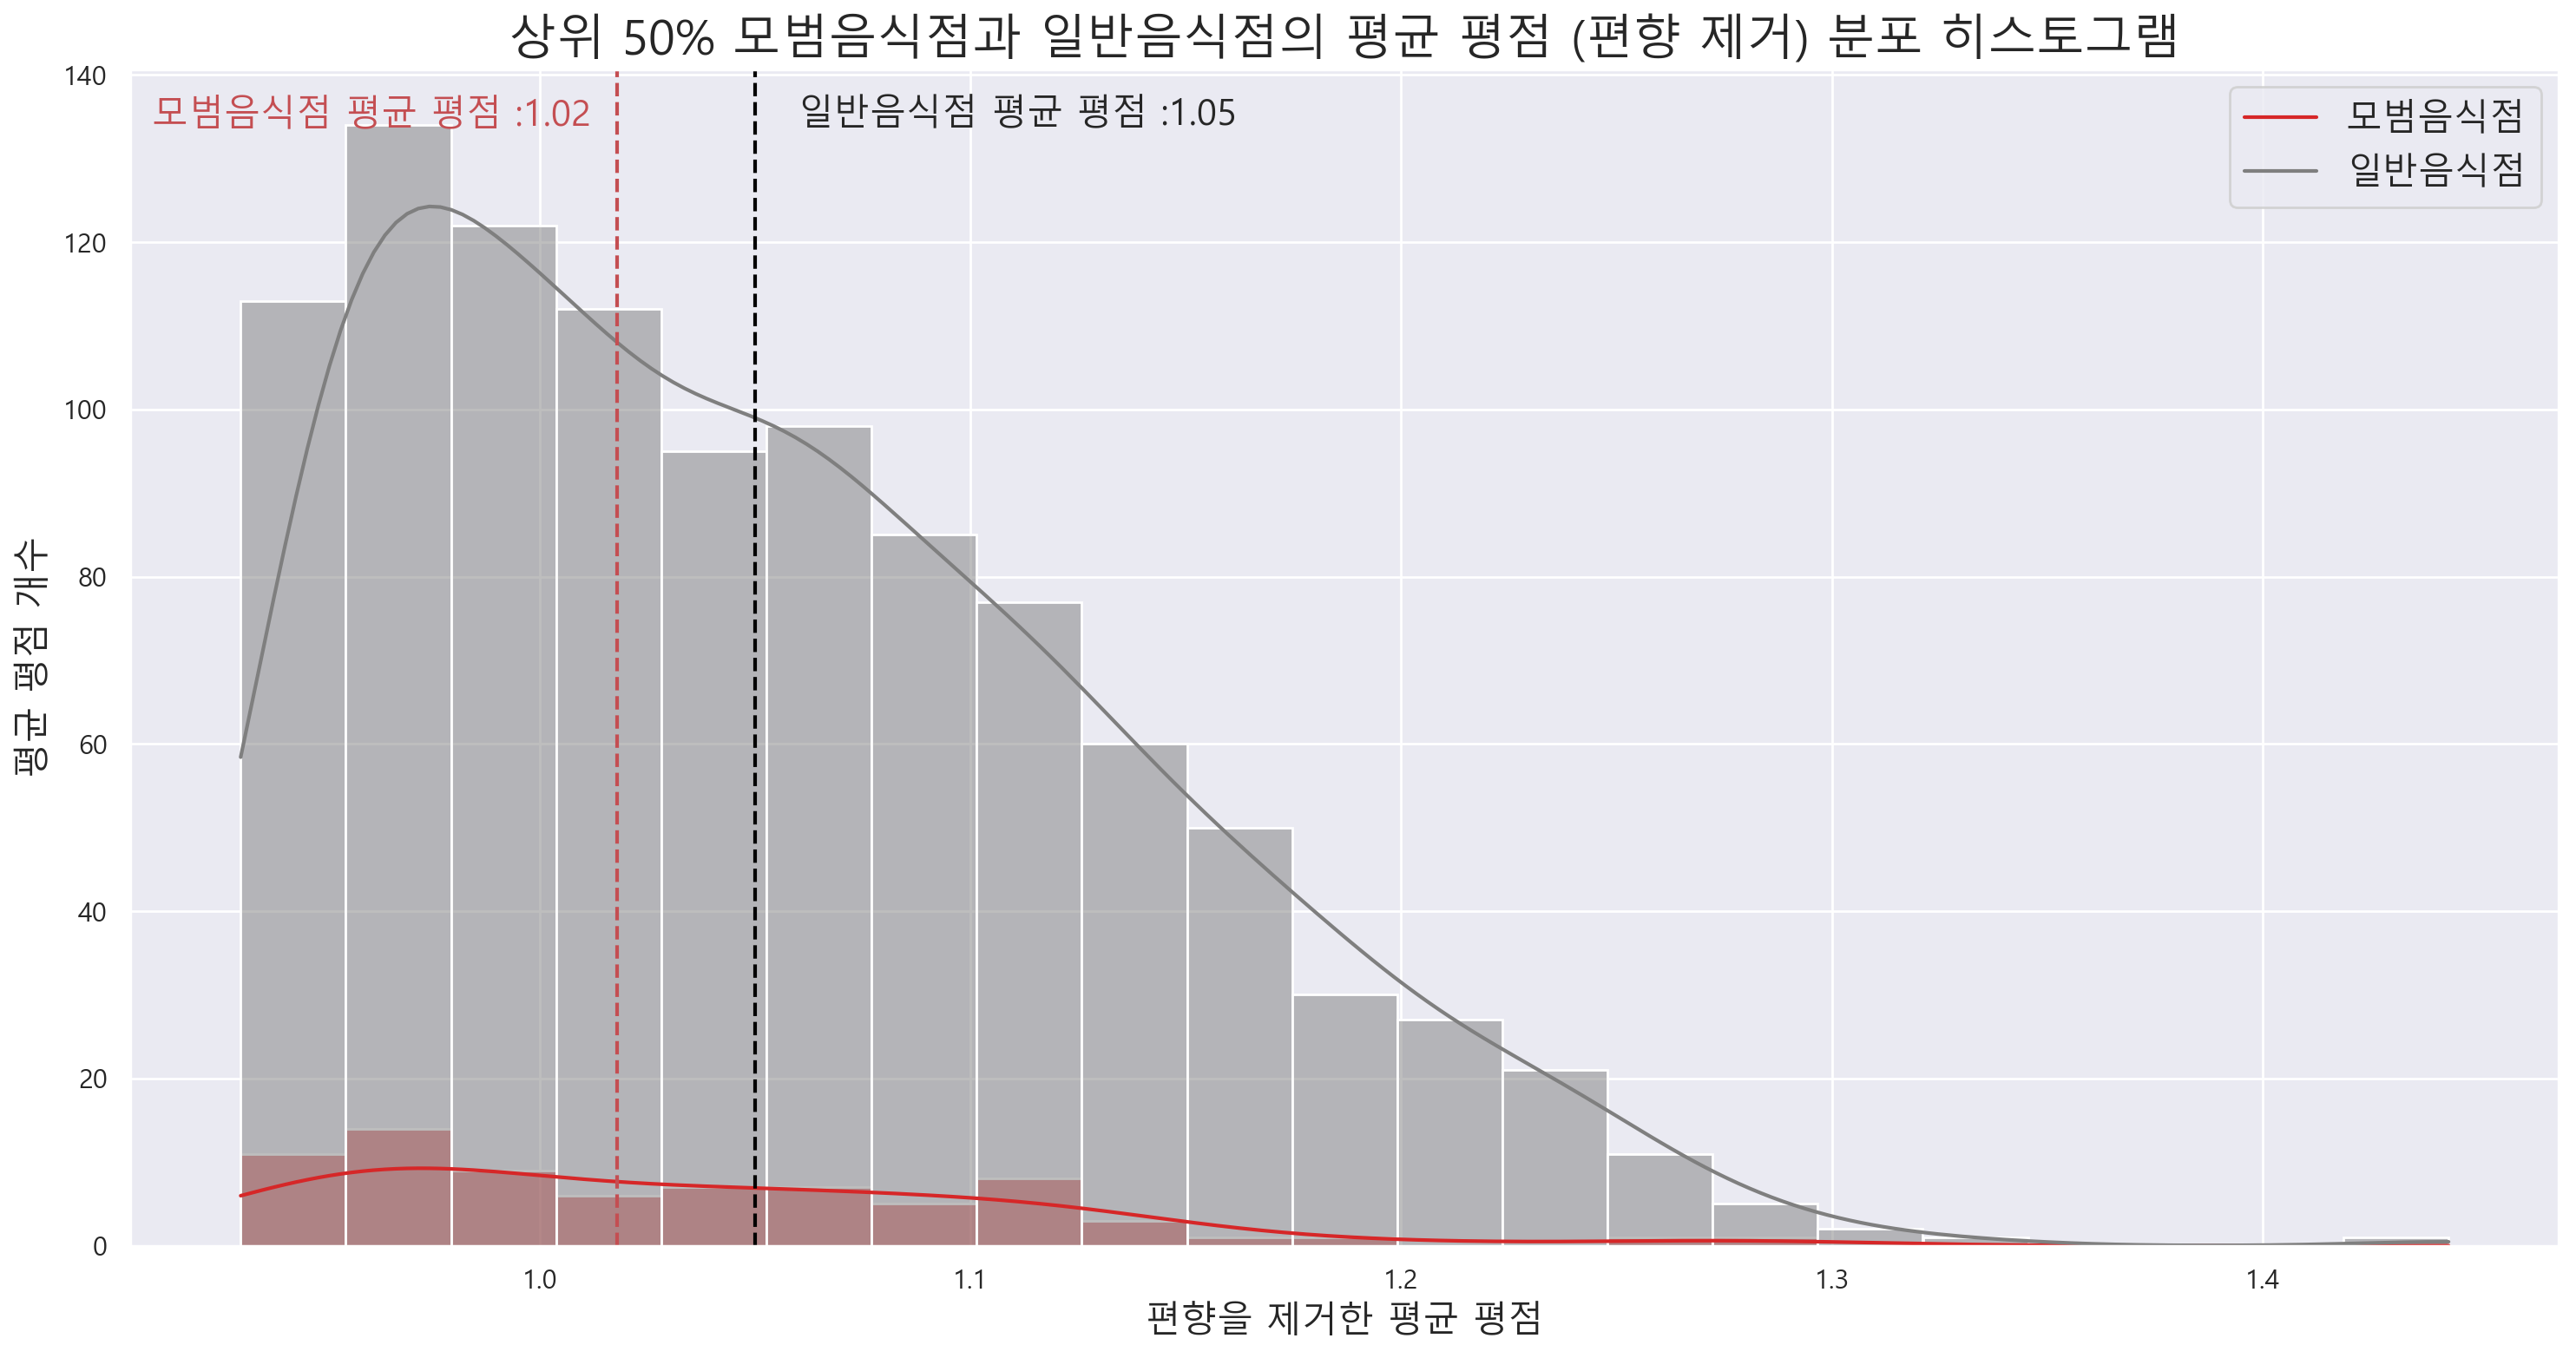

In [115]:
# 상위 50% 모범 음식점, 일반 음식점의 편향을 제거한 평균 평점 분포와 평균 비교

palette = ['tab:grey', 'tab:red']

plt.figure(figsize=(15, 8))
sns.histplot(data=reviews_group_50, x="rate_gmean", hue="is_model_b", kde=True, palette=palette)

plt.axvline(stats.gmean(reviews_group_model_50["rate_gmean"]), color="r", linestyle="--")
plt.axvline(stats.gmean(reviews_group_no_model_50["rate_gmean"]), color="black", linestyle="--")

plt.text(0.910, 134, "모범음식점 평균 평점 :"+str(round(stats.gmean(reviews_group_model_50["rate_gmean"]),2)), 
         color="r", 
         size=15, 
        #  weight="bold"
        )

plt.text(1.06, 134, "일반음식점 평균 평점 :"+str(round(stats.gmean(reviews_group_no_model_50["rate_gmean"]),2)), 
         size=15, 
        #  weight="bold"
        )


plt.legend(("모범음식점", "일반음식점"), 
        #    prop={'weight':'bold'}
           )
plt.rc("legend", fontsize=15)


plt.xlabel("편향을 제거한 평균 평점", size=15)
plt.ylabel("평균 평점 개수", size=15)

plt.title("상위 50% 모범음식점과 일반음식점의 평균 평점 (편향 제거) 분포 히스토그램", size=20)

plt.tight_layout()
plt.show()


#### 정규성 검정

In [117]:
# 음식점으로 groupby한 데이터
normal_check(reviews_group_model_50)

Anderson-Darling 검정통계량: 1.5776951859241706
Anderson-Darling 검정결과 : 유의수준 5.0에서 검정통계량 1.5776951859241706이 기각역 0.753 보다 크기 때문에 정규성을 만족하지 않는다


In [118]:
# 음식점으로 groupby한 데이터
normal_check(reviews_group_no_model_50)

Anderson-Darling 검정통계량: 14.069199832591494
Anderson-Darling 검정결과 : 유의수준 5.0에서 검정통계량 14.069199832591494이 기각역 0.784 보다 크기 때문에 정규성을 만족하지 않는다


#### 비모수적 검정
- 데이터가 정규성을 따르지 않는 것 확인

In [120]:
non_parametic_check(reviews_group_model_50, reviews_group_no_model_50, "log_rate_gmean", alternative="less")

Mann-Whitney U test 통계량: 32413.5
p-value: 0.00017513014985511233
검정결과 : 귀무가설을 기각한다


##### 결론
- p-value < 0.05, 상위 50% 모범 음식점과 상위 50% 일반 음식점 평균 평점이 같다는 귀무가설 기각

- 상위 50% 모범 음식점의 평균 평점이 상위 50% 일반 음식점 평균 평점보다 작다 (대립가설 채택)

    - 모범 음식점이 오히려 일반 음식점보다 평점이 낮다
    
    - 평균 평점 상위 50%에 대해, 모범 음식점 지정 제도는 올바르게 기능하고 있다고 볼 수 있을까?

### 6. 하위권 강남구 모범음식점의 평균 평점이 하위권 강남구 일반음식점 평균과 유의미하게 다를까?

- 전체적으로 모범음식점, 일반음식점의 평균 평점 차이가 존재한다 (가설 4에서 확인)

- 그렇다면, 하위권 강남구 모범음식점의 평균 평점이 하위권 강남구 일반음식점 평균 평점과 같을까?

    - 귀무가설 : 하위권 강남구 모범음식점의 평균 평점이 하위권 강남구 일반음식점 평균 평점과 같다
    
    - 대립가설 : 하위권 강남구 모범음식점의 평균 평점이 하위권 강남구 일반음식점 평균 평점보다 작다    

In [130]:
def bottom_by_pct(data, bottom_pct=0.75):
    temp = data.sort_values("rate_gmean", ascending=True)
    temp = temp[temp.rate_gmean<temp.rate_gmean.quantile(bottom_pct)]
    return temp

In [131]:
# 평균 평점 하위 50%인 음식점 필터링
bottom_pct = 0.5
reviews_group_50_bot = bottom_by_pct(reviews_group, bottom_pct)
reviews_group_model_50_bot = bottom_by_pct(reviews_group_model, bottom_pct)
reviews_group_no_model_50_bot = bottom_by_pct(reviews_group_no_model, bottom_pct)

In [132]:
reviews_group_50_bot.shape, reviews_group_model_50_bot.shape, reviews_group_no_model_50_bot.shape

((1117, 5), (82, 5), (1035, 5))

#### 시각화
- 시각화 결과, 하위 50% 일반 음식점의 평균 평점이 모범 음식점의 평균 평점과 크게 차이나는 것처럼 보이지는 않는다

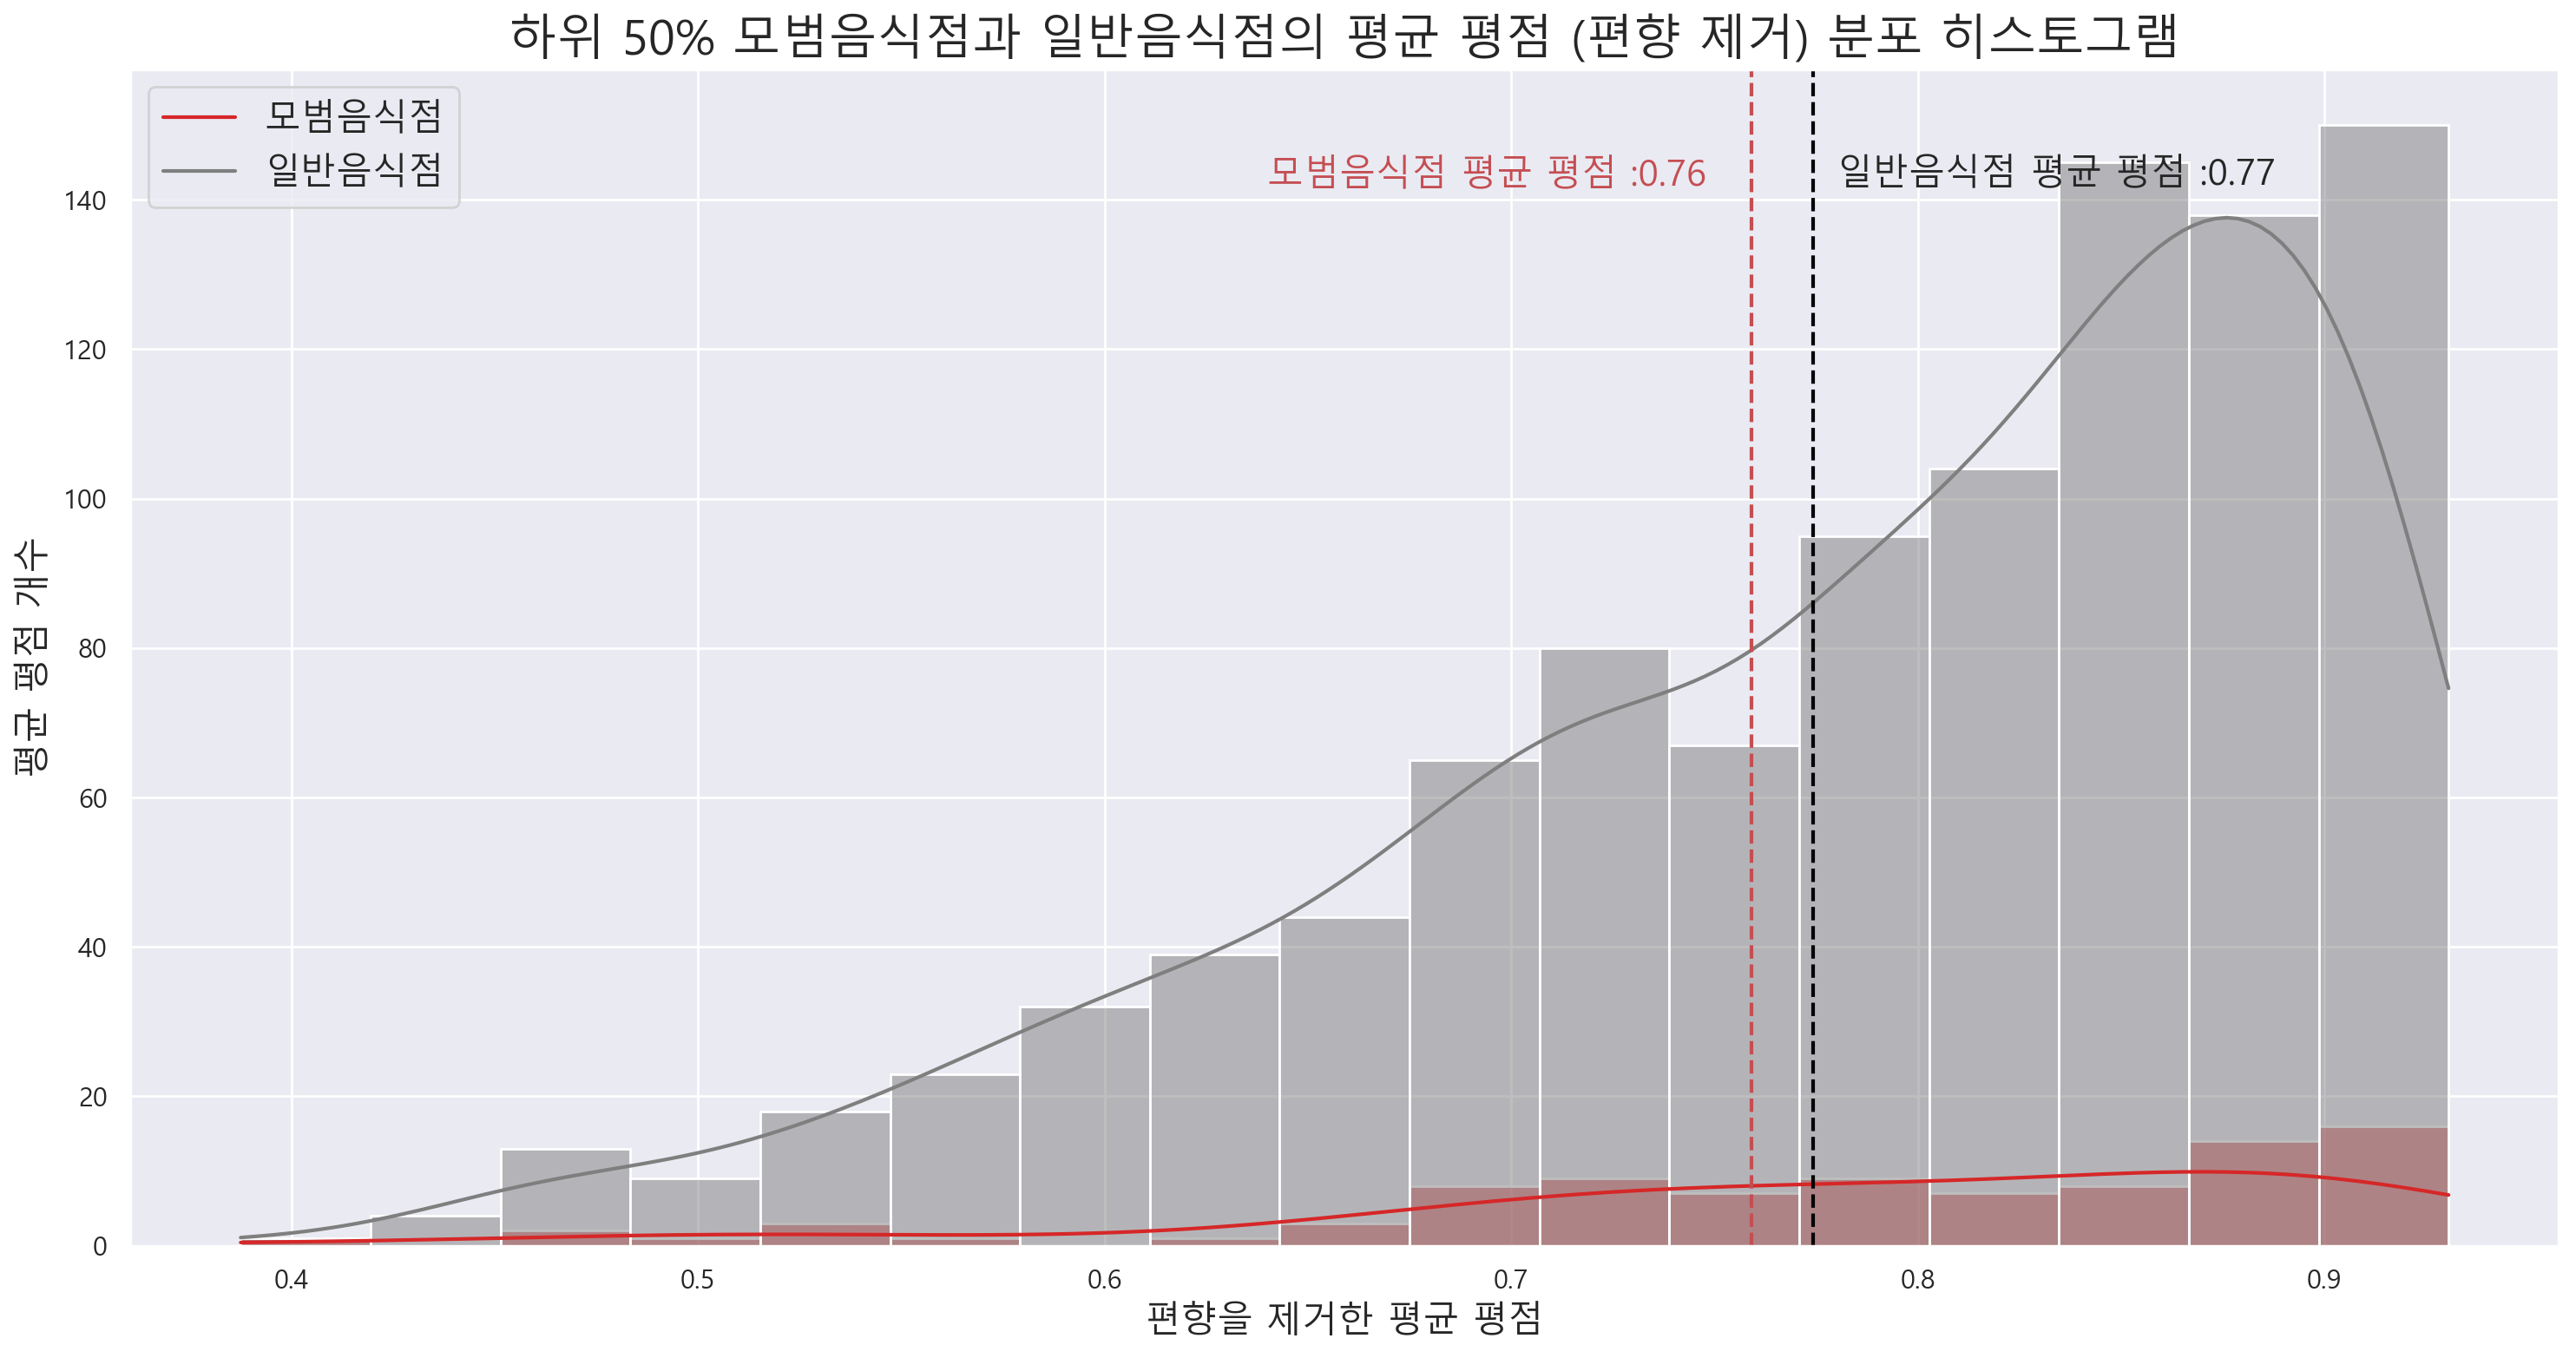

In [140]:
# 하위 50% 모범 음식점, 일반 음식점의 편향을 제거한 평균 평점 분포와 평균 비교

palette = ['tab:grey', 'tab:red']

plt.figure(figsize=(15, 8))
sns.histplot(data=reviews_group_50_bot, x="rate_gmean", hue="is_model_b", kde=True, palette=palette)

plt.axvline(stats.gmean(reviews_group_model_50_bot["rate_gmean"]), color="r", linestyle="--")
plt.axvline(stats.gmean(reviews_group_no_model_50_bot["rate_gmean"]), color="black", linestyle="--")

plt.text(0.64, 142, "모범음식점 평균 평점 :"+str(round(stats.gmean(reviews_group_model_50_bot["rate_gmean"]),2)), 
         color="r", 
         size=15, 
        #  weight="bold"
        )

plt.text(0.78, 142, "일반음식점 평균 평점 :"+str(round(stats.gmean(reviews_group_no_model_50_bot["rate_gmean"]),2)), 
         size=15, 
        #  weight="bold"
        )


plt.legend(("모범음식점", "일반음식점"), 
        #    prop={'weight':'bold'}
           )
plt.rc("legend", fontsize=15)


plt.xlabel("편향을 제거한 평균 평점", size=15)
plt.ylabel("평균 평점 개수", size=15)

plt.title("하위 50% 모범음식점과 일반음식점의 평균 평점 (편향 제거) 분포 히스토그램", size=20)

plt.tight_layout()
plt.show()


#### 정규성 검정

In [141]:
# 음식점으로 groupby한 데이터
normal_check(reviews_group_model_50_bot)

Anderson-Darling 검정통계량: 2.0566688033250387
Anderson-Darling 검정결과 : 유의수준 5.0에서 검정통계량 2.0566688033250387이 기각역 0.753 보다 크기 때문에 정규성을 만족하지 않는다


In [142]:
# 음식점으로 groupby한 데이터
normal_check(reviews_group_no_model_50_bot)

Anderson-Darling 검정통계량: 22.53003330912611
Anderson-Darling 검정결과 : 유의수준 5.0에서 검정통계량 22.53003330912611이 기각역 0.784 보다 크기 때문에 정규성을 만족하지 않는다


#### 비모수적 검정
- 데이터가 정규성을 따르지 않는 것 확인

In [143]:
non_parametic_check(reviews_group_model_50_bot, reviews_group_no_model_50_bot, "log_rate_gmean", alternative="less")

Mann-Whitney U test 통계량: 39226.5
p-value: 0.12696702111965452
검정결과 : 5% 유의수준에서 귀무가설을 채택한다


##### 결론
- p-value < 0.05, 하위 50% 모범 음식점과 하위 50% 일반 음식점 평균 평점이 같다는 귀무가설 채택

- 하위 50%에 대해서는 모범 음식점 지정 여부가 평균 평점과 관련이 없다 

    - 모범 음식점 제도가 제대로 기능하고 있는 것이 맞을까?